# T_SNE Visualisation

Chris done great investigation <a href="https://www.kaggle.com/cdeotte/support-vector-machine-0-925">here</a>, that `wheezy-copper-turtle-magic` value identifies one of 512 datasets, combined in one. <br>
All datasets have target that **non-linarly** dependent on approximately 40 features, that have std > 1. <br>
I decided to check how well t-sne will work with these datasets.

# Load data

In [1]:
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

from tqdm import tqdm_notebook

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
test['target'] = 'unknown'

# Plot functions 
I would like to thank @allunia for pretty `plot_3d` function taken from <a href="https://www.kaggle.com/allunia/instant-gratification-some-eda-to-go">here</a>.

In [2]:
def plot_2d(df, x, y):
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x=x, y=y,
        hue='target',
        palette=sns.color_palette('bright', 3),
        data=df,
        legend='full',
        alpha=0.9
    )
    plt.show()
    

def plot_3d(df, x, y, z):
    trace1 = go.Scatter3d(x=df[x].values, y=df[y].values, z=df[z].values,
        mode='markers',
        marker=dict(
            color=df['target'].values,
            colorscale = "Jet",
            opacity=0.,
            size=2
        )
    )

    figure_data = [trace1]
    layout = go.Layout(
        scene = dict(
            xaxis = dict(title=x),
            yaxis = dict(title=y),
            zaxis = dict(title=z),
        ),
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        showlegend=True
    )

    fig = go.Figure(data=figure_data, layout=layout)
    py.iplot(fig, filename='3d_scatter')

# Choose one of datasets and reduce amount of columns

In [3]:
MAGIC_N = 42
train_subset = train[train['wheezy-copper-turtle-magic'] == MAGIC_N]
test_subset = test[test['wheezy-copper-turtle-magic'] == MAGIC_N]
concated = pd.concat([train_subset, test_subset])

a = train_subset.std() > 1.2
cols = [idx for idx in a.index if a[idx]]
concated = concated[cols + ['target']]

# Non-linear dimensionality reduction to 2 dims

In [4]:
X_embedded = TSNE(n_components=2, perplexity=25, random_state=50).fit_transform(concated[cols].values)
concated['tsne2_1'] = X_embedded[:, 0]
concated['tsne2_2'] = X_embedded[:, 1]

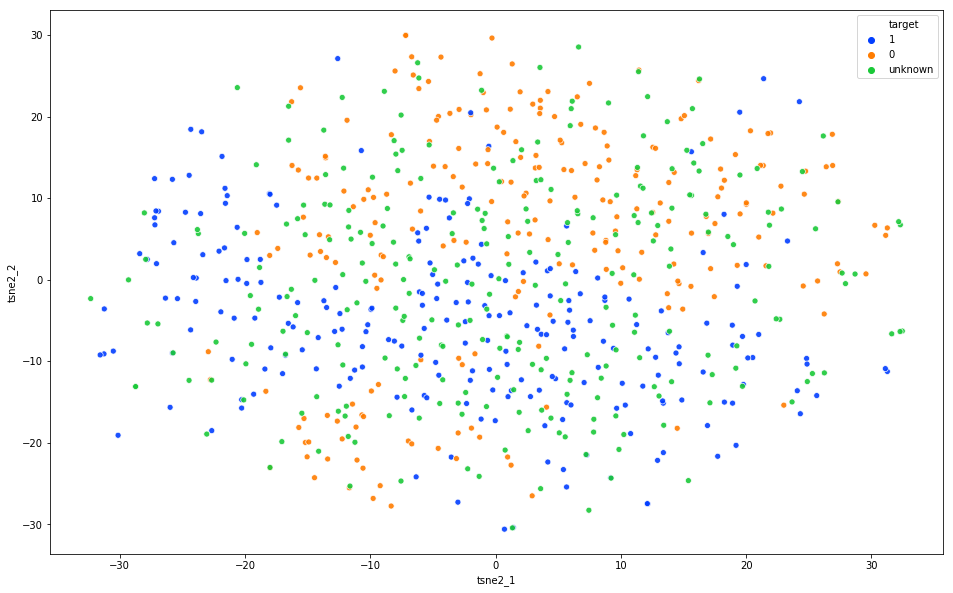

In [5]:
plot_2d(concated, x='tsne2_1', y='tsne2_2')

Wow! It works pretty well. Blue and orange points looks differentiable. Probabaly some tree-based method will work with this.

# Non-linear dimensionality reduction to 3 dims

In [6]:
X_embedded = TSNE(n_components=3, perplexity=20, random_state=42).fit_transform(concated[cols].values)
concated['tsne3_1'] = X_embedded[:, 0]
concated['tsne3_2'] = X_embedded[:, 1]
concated['tsne3_3'] = X_embedded[:, 2]

In [7]:
concated = concated.reset_index(drop=True)
plot_3d(concated.loc[:len(train_subset)-1], x='tsne3_1', y='tsne3_2', z='tsne3_3')

# Let's check how catboost will deal with it

In [8]:
train_projected = concated.loc[:len(train_subset)-1][['tsne2_1', 'tsne2_2', 'target']]
train_projected['target'] = train_projected['target'].values.astype(int)

oof = np.zeros(len(train_projected))

skf = StratifiedKFold(n_splits=5, random_state=42)
for trn_idx, val_idx in skf.split(train_projected['target'], train_projected['target']):
    X_tr, y_tr = train_projected.loc[trn_idx][['tsne2_1', 'tsne2_2']], train_projected.loc[trn_idx]['target']
    X_val, y_val = train_projected.loc[val_idx][['tsne2_1', 'tsne2_2']], train_projected.loc[val_idx]['target']
    
    clf = CatBoostClassifier(depth=5, eval_metric='AUC')
    clf.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=333)
    oof[val_idx] = clf.predict(X_val)

Learning rate set to 0.070412
0:	test: 0.8054078	best: 0.8054078 (0)	total: 63.3ms	remaining: 1m 3s
333:	test: 0.8608156	best: 0.8878546 (40)	total: 4.25s	remaining: 8.48s
666:	test: 0.8621454	best: 0.8878546 (40)	total: 8.27s	remaining: 4.13s
999:	test: 0.8652482	best: 0.8878546 (40)	total: 12s	remaining: 0us

bestTest = 0.8878546099
bestIteration = 40

Shrink model to first 41 iterations.
Learning rate set to 0.070412
0:	test: 0.7234043	best: 0.7234043 (0)	total: 12ms	remaining: 12s
333:	test: 0.8537234	best: 0.8807624 (99)	total: 3.85s	remaining: 7.67s
666:	test: 0.8421986	best: 0.8807624 (99)	total: 7.64s	remaining: 3.82s
999:	test: 0.8448582	best: 0.8807624 (99)	total: 11.5s	remaining: 0us

bestTest = 0.8807624113
bestIteration = 99

Shrink model to first 100 iterations.
Learning rate set to 0.070432
0:	test: 0.8202807	best: 0.8202807 (0)	total: 13.7ms	remaining: 13.7s
333:	test: 0.8990493	best: 0.9004074 (290)	total: 3.74s	remaining: 7.46s
666:	test: 0.9157990	best: 0.9171571 (65

In [9]:
auc_score = roc_auc_score(train_projected['target'], oof)
print(f'AUC on wheezy-copper-turtle-magic={MAGIC_N} is - {auc_score}')

AUC on wheezy-copper-turtle-magic=42 is - 0.8642215730823326


Score is not so high, but probably these features can be combined with original and you will have some boost. <br>
**But be careful!** Results will be different because it will work on unseen private set.

## Thank you for reading!